# Run to Failure degradation simulation of NASA Turbo Jet Engine Fans

# <a id='index'>Index</a>

+ <a href='#data_analysis'>1. Data Analysis</a>
    + <a href='#info_about_data'>1.1 Info about data:</a>
+ <a href='#noise_removal'>2. Noise removal and Normalization</a>
+ <a href='#training_and_validation'>3. Training and Validation</a>
+ <a href='#testing'>4 Testing</a>

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import QuantileTransformer , PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from keras import optimizers
from keras.models import Sequential
from keras.layers import TimeDistributed, Flatten
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

# <a id='data_analysis'>1. Data analysis</a>
<a href='#index'>Go back to Index</a>

In [37]:
train_file = "train_FD001.txt" 
test_file = "test_FD001.txt"
RUL_file = "RUL_FD001.txt"

df = pd.read_csv(train_file,sep=" ",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [38]:
#columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
#           'Nc','epr','Ps3 0','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
#delete NaN values
df.drop(columns=[26,27],inplace=True)
columns = ["Section-{}".format(i)  for i in range(26)]
df.columns = columns
df.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


#### Dataset statistics  for each parameter

In [39]:
df.describe()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


## <a id='info_about_data'>1.1 Info about data:</a>
- Section-0 is MachineID
- Section-1 is time in, Cycles
- Section-2...4 is Opertional Settings
- Section-5...25 is sensor's data 


- Data Set: FD001
- Train trjectories: 100
- Test trajectories: 100
- Conditions: ONE (Sea Level)
- Fault Modes: ONE (HPC Degradation)

In [40]:
# Names 
MachineID_name = ["Section-0"]
RUL_name = ["Section-1"]
OS_name = ["Section-{}".format(i) for i in range(2,5)]
Sensor_name = ["Section-{}".format(i) for i in range(5,26)]

# Data in pandas DataFrame
MachineID_data = df[MachineID_name]
RUL_data = df[RUL_name]
OS_data = df[OS_name]
Sensor_data = df[Sensor_name]

# Data in pandas Series
MachineID_series = df["Section-0"]
RUL_series = df["Section-1"]

In [41]:
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
print("Max Life >> ",max(max_cycles))
print("Mean Life >> ",np.mean(max_cycles))
print("Min Life >> ",min(max_cycles))

Max Life >>  362
Mean Life >>  206.31
Min Life >>  128


From the above vizulization its clear that 
- Section-4 (Oprational Setting-3)
- Section-5 (Sensor-1)
- Section-9  (Sensor-5)
- Section-14 (Sensor-10)
- Section-20 (Sensor-16)
- Section-22 (Sensor-18)
- Section-23 (Sensor-19)

Does not play a vital role in variation of data and there std is also almost 0 so, these sensor data is useless for us hence, we can drop this coloumn data

In [42]:
#delete columns with constant values that do not carry information about the state of the unit
#data = pd.concat([RUL_data,OS_data,Sensor_data], axis=1)
df.drop(columns=["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"] , inplace=True)

In [43]:
df.head()

,Section-1,Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


# <a id='noise_removal'>2. Noise removal and Normalization</a>
<a href='#index'>Go back to Index</a>

In [44]:
print(type(df))
gen = MinMaxScaler(feature_range=(0, 1))
df = gen.fit_transform(df)
df = pd.DataFrame(df)
#df = df.rolling(20).mean()
pt = PowerTransformer()
df = pt.fit_transform(df)

<class 'pandas.core.frame.DataFrame'>


In [45]:
# grouping w.r.t MID (Machine ID)
# col_names = df.columns
# def grouping(datafile, mid_series):
#     data = [x for x in datafile.groupby(mid_series)]
#     return data 

In [46]:
df

array([[-1.84688137, -0.31975365, -1.3916867 , ..., -0.76399955,
         1.42665355,  1.24248381],
       [-1.82422371,  0.87202066, -1.03174892, ..., -0.76399955,
         1.03734696,  1.29226848],
       [-1.80166973, -1.9503069 ,  1.01385485, ..., -2.35059786,
         0.72414823,  0.465476  ],
       ...,
       [ 1.25582441,  0.18308976,  0.01311911, ...,  2.66650739,
        -1.90974435, -2.75272539],
       [ 1.26682846, -0.50209065,  1.01385485, ...,  1.14636389,
        -2.49938469, -1.91568423],
       [ 1.27779988, -1.45465135, -1.75831429, ...,  1.68933126,
        -2.19492018, -1.99819889]])

# <a id='training_and_validation'>3. Training and Validation using LSTM</a>
<a href='#index'>Go back to Index</a>

In [47]:
def RUL_df():
    rul_lst = [j  for i in MachineID_series.unique() for j in np.array(grp.get_group(i)[::-1]["Section-1"])]
    rul_col = pd.DataFrame({"rul":rul_lst})
    return rul_col

df_rul = RUL_df()
print(df_rul.head())
df_rul = np.array(df_rul)

   rul
0  192
1  191
2  190
3  189
4  188


In [50]:
X = df

Y = np.array(RUL_df()).reshape(-1,1)
#Y = RUL_df()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20) 

print(type(X),type(Y))

kf = KFold(n_splits=15 ,shuffle=True)

for i in range(10):
    result=next(kf.split(X_train),None)
    print(result[0],result[1])
    print(len(result[0]),len(result[1]))
print(result[0][2])

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[    0     1     2 ... 16501 16502 16503] [   23    42    51 ... 16464 16485 16487]
15403 1101
[    0     1     2 ... 16500 16501 16502] [   27    34    50 ... 16483 16488 16503]
15403 1101
[    0     1     2 ... 16501 16502 16503] [    6    13    15 ... 16431 16487 16498]
15403 1101
[    0     2     3 ... 16501 16502 16503] [    1    13    30 ... 16465 16474 16481]
15403 1101
[    0     1     2 ... 16501 16502 16503] [    6    19    29 ... 16458 16473 16481]
15403 1101
[    0     1     2 ... 16501 16502 16503] [   34    45    49 ... 16453 16460 16461]
15403 1101
[    0     1     2 ... 16501 16502 16503] [   12    32    35 ... 16467 16471 16475]
15403 1101
[    0     1     2 ... 16501 16502 16503] [   28    29    40 ... 16438 16470 16490]
15403 1101
[    0     1     2 ... 16501 16502 16503] [   13    16    26 ... 16462 16476 16498]
15403 1101
[    0     1     2 ... 16500 16501 16503] [   19    21    38 ... 16457 16474 16502]
15403 1101
2


In [51]:
logistic_model = LogisticRegression()
scores=[]
for i in range(5):
    result=next(kf.split(X_train),None)
    x_train=[]
    y_train=[]
    x_test=[]
    y_test=[]
    for j in range(len(result[0])):
        x_train.append(X_train[result[0][j]])
        y_train.append(Y_train[result[0][j]])
    for j in range(len(result[1])):
        x_test.append(X_train[result[1][j]])
        y_test.append(Y_train[result[1][j]])
    x_train,y_train=np.array(x_train),np.array(y_train)
    x_test,y_test=np.array(x_test),np.array(y_test)
    print("Epoch number :",i+1)
    print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
    logistic_model.fit(x_train,y_train)
    scores.append(logistic_model.score(x_test,y_test))
    print("Score :",logistic_model.score(x_test,y_test))
print("Average score:",np.mean(scores))
logistic_model.fit(X_train, Y_train)

Epoch number : 1
(15403, 17) (15403, 1) (1101, 17) (1101, 1)
Score : 0.018165304268846504
Epoch number : 2
(15403, 17) (15403, 1) (1101, 17) (1101, 1)
Score : 0.023614895549500452
Epoch number : 3
(15403, 17) (15403, 1) (1101, 17) (1101, 1)
Score : 0.019981834695731154
Epoch number : 4
(15403, 17) (15403, 1) (1101, 17) (1101, 1)
Score : 0.01725703905540418
Epoch number : 5
(15403, 17) (15403, 1) (1101, 17) (1101, 1)
Score : 0.02089009990917348
Average score: 0.019981834695731154


LogisticRegression()

In [52]:
print("Acc of Logistic Regression >> ",logistic_model.score(X_test, Y_test))

Acc of Logistic Regression >>  0.01889992730797189


In [53]:
### <a id='3.3.1'>3.3.1 Logistic Regression Validation Performance</a>

logistic_pred = logistic_model.predict(X_test)
print("mean_squared_error >> ", mean_squared_error(Y_test, logistic_pred))
print("mean_absolute_error >>",mean_absolute_error(Y_test, logistic_pred))

mean_squared_error >>  1769.2503028834506
mean_absolute_error >> 28.792827719893385


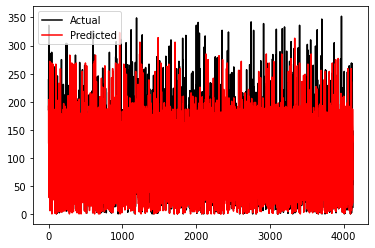

In [54]:
### <a id='3.3.2'>3.3.2 Logistic Regression Validation Prediction vs Actual</a>

plt.plot(Y_test,c='k',label='Actual')
plt.plot(logistic_pred,c='red',label='Predicted')
plt.legend()
plt.show()

# <a id='testing'>4 Testing</a>
<a href='#index'>Go back to Index</a>

In [55]:
df_test = pd.read_csv(test_file, sep=" ",header=None)
df_test.drop(columns=[26,27],inplace=True)
df_test.columns = columns
df_test.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [56]:
df_test_rul = pd.read_csv(RUL_file, names=['rul'])
df_test_rul.head()

,rul
0,112
1,98
2,69
3,82
4,91


In [57]:
RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])

In [58]:
print(max_cycles)

[ 31  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]


In [59]:
df_test.drop(df_test[["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"]], axis=1 , inplace=True)
#df_test = df_test.groupby(["Section-0"])
#print(df_test)


In [60]:
gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
pt = PowerTransformer()
df_test = pt.fit_transform(df_test)
df_test=np.nan_to_num(df_test)

In [61]:
test_data = []
i = 0
count = 0
while i < len(df_test):
    temp = []
    j = int(max_cycles[count])
    count = count+1
    print(j)
    if j == 0:
        break
    while j!=0:
        temp.append(df_test[i])
        i=i+1
        j=j-1
    test_data.append(temp)

31
49
126
106
98
105
160
166
55
192
83
217
195
46
76
113
165
133
135
184
148
39
130
186
48
76
140
158
171
143
196
145
50
203
198
126
121
125
37
133
123
156
172
54
152
146
73
78
303
74
144
189
164
121
113
136
160
176
94
147
159
232
155
168
71
147
71
187
54
152
68
131
112
137
88
205
162
72
101
133
213
162
73
172
34
110
56
68
177
146
234
150
244
133
89
97
134
121
97
198


In [62]:
print(len(test_data))

100


In [63]:
y_new = []
for i in range(len(test_data)):
    y_new.append(pd.DataFrame(test_data[i]))

y_new[1]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-1.793850,-0.403908,1.327938,0.491476,0.264432,0.414832,-0.930599,0.549425,-2.091438,0.139549,-0.291073,1.195698,-0.972686,0.128797,-0.435852,0.748684,0.655920
1,-1.759832,-0.494678,0.677007,0.124510,0.091941,0.167868,-0.390194,0.039405,-0.328605,0.240686,0.447638,0.209360,-2.364091,0.569061,0.378493,-0.405454,-0.574031
2,-1.726093,0.095455,1.004600,0.297019,1.470300,0.931735,-0.658122,1.031562,-2.687990,0.240686,-0.852788,0.209360,-1.352862,-1.645776,1.148940,0.899581,0.835040
3,-1.692628,1.140251,0.344897,-0.381088,-0.930734,0.567578,0.546454,1.186557,-1.118874,0.088446,-0.378925,-0.143646,-0.931472,0.329208,0.378493,-0.543059,1.669632
4,-1.659435,0.186271,-1.395065,0.754319,-0.597428,0.477975,0.280052,1.031562,-1.535407,0.340425,-0.343903,0.715408,-1.316947,0.004742,-0.435852,-0.611304,0.620619
5,-1.626511,-0.358520,-1.035151,0.099683,-1.694581,-0.320162,-0.009098,0.713093,-1.742885,0.956764,0.033405,-0.143646,-1.073174,-0.222763,-0.435852,-0.813804,-0.816911
6,-1.593852,0.867611,0.007977,0.418886,1.223617,0.154514,-0.347077,1.186557,-0.729036,0.583861,-1.357336,0.034494,-1.308691,-0.469407,0.378493,-1.012946,2.391391
7,-1.561456,0.685883,1.004600,0.370273,-0.972818,0.034889,-0.903790,0.039405,-0.677335,0.036981,-0.112400,1.350488,-0.355285,0.621678,-1.300958,-0.746677,-1.308672
8,-1.529320,-0.993778,1.004600,-0.458622,0.153580,0.469392,-0.781945,0.382663,-0.596323,0.340425,-0.534577,0.209360,-0.730091,0.716429,-0.435852,-1.273230,-0.769650
9,-1.497440,0.958485,1.327938,0.174027,0.571892,0.251963,-0.504089,0.873772,-0.308210,0.340425,-1.172699,0.549714,-1.790488,-0.120693,-0.435852,0.159801,0.009971


In [64]:
predictions = []
for i in range(len(y_new)):
    test_model = VAR(y_new[i])
    test_model_fit = test_model.fit()
    test_pred = test_model_fit.forecast(test_model_fit.y, steps=1)
    predictions.append(test_pred)

In [68]:
predictions

[array([[-0.85567316, -0.82605876, -1.2757901 , -0.69715895,  0.52116256,
         -0.95566971,  1.3599868 ,  0.16559863,  0.14891246, -0.92084677,
         -0.22972109, -0.50735   , -0.8031758 , -0.24820627,  2.53645812,
          0.1863466 ,  0.14761735]]),
 array([[-0.40401262,  0.13624987, -0.51713254,  1.01224692,  0.25974057,
          0.0083473 , -0.57601475,  1.19484199, -1.5002636 ,  0.52973881,
         -0.95413642,  1.03141803, -1.53302247,  1.10100473, -0.01420615,
         -0.0404995 , -0.86856948]]),
 array([[ 1.01248148,  0.52780238,  0.31802031,  1.09361862,  0.39291028,
          1.16253778, -0.77255705,  1.22741744, -0.30242466,  1.16495168,
         -1.19576263,  1.1765574 , -1.26669904,  1.13987875,  0.36614571,
         -0.29270493, -0.97976668]]),
 array([[ 0.70792743, -0.37353942, -0.80868057,  0.82289048,  0.75780608,
          0.83768141, -0.31511432,  1.09272978, -1.05551232,  1.04693653,
         -0.68666313,  0.81298535, -0.71938603,  0.70686772,  0.05038431

In [72]:
predictions[0].shape

(1, 17)

In [73]:
logistic_pred = []
for i in range(100):
    logistic_pred.append(logistic_model.predict(predictions[i]))
#logistic_pred = np.array(logistic_pred)

In [76]:
logistic_pred = np.array(logistic_pred)

In [80]:
len(logistic_pred)

100

In [82]:
y_test = np.array(df_test_rul)

In [83]:
len(y_test)

100

In [211]:
y_test

array([[112],
       [ 98],
       [ 69],
       [ 82],
       [ 91],
       [ 93],
       [ 91],
       [ 95],
       [111],
       [ 96],
       [ 97],
       [124],
       [ 95],
       [107],
       [ 83],
       [ 84],
       [ 50],
       [ 28],
       [ 87],
       [ 16],
       [ 57],
       [111],
       [113],
       [ 20],
       [145],
       [119],
       [ 66],
       [ 97],
       [ 90],
       [115],
       [  8],
       [ 48],
       [106],
       [  7],
       [ 11],
       [ 19],
       [ 21],
       [ 50],
       [142],
       [ 28],
       [ 18],
       [ 10],
       [ 59],
       [109],
       [114],
       [ 47],
       [135],
       [ 92],
       [ 21],
       [ 79],
       [114],
       [ 29],
       [ 26],
       [ 97],
       [137],
       [ 15],
       [103],
       [ 37],
       [114],
       [100],
       [ 21],
       [ 54],
       [ 72],
       [ 28],
       [128],
       [ 14],
       [ 77],
       [  8],
       [121],
       [ 94],
       [118],
      

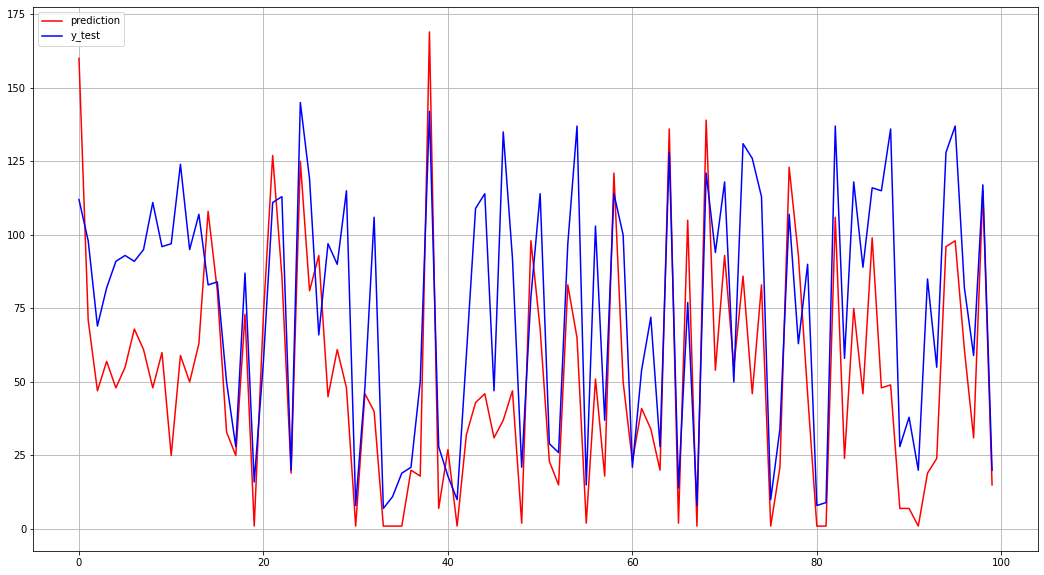

In [85]:
fig = plt.figure(figsize=(18,10))
plt.plot(logistic_pred,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [86]:
print("mean_squared_error >> ", mean_squared_error(y_test,logistic_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,logistic_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_test,logistic_pred))

mean_squared_error >>  1310.52
root_mean_squared_error >>  36.201104955512065
mean_absolute_error >> 29.14


In [95]:
a = y_test

In [96]:
my_pred = logistic_pred

In [97]:
actual = []
for i in range(len(a)):
    actual.append(a[i][0])

In [98]:
print(actual)

[112, 98, 69, 82, 91, 93, 91, 95, 111, 96, 97, 124, 95, 107, 83, 84, 50, 28, 87, 16, 57, 111, 113, 20, 145, 119, 66, 97, 90, 115, 8, 48, 106, 7, 11, 19, 21, 50, 142, 28, 18, 10, 59, 109, 114, 47, 135, 92, 21, 79, 114, 29, 26, 97, 137, 15, 103, 37, 114, 100, 21, 54, 72, 28, 128, 14, 77, 8, 121, 94, 118, 50, 131, 126, 113, 10, 34, 107, 63, 90, 8, 9, 137, 58, 118, 89, 116, 115, 136, 28, 38, 20, 85, 55, 128, 137, 82, 59, 117, 20]


In [99]:
print(my_pred)

[[160]
 [ 71]
 [ 47]
 [ 57]
 [ 48]
 [ 55]
 [ 68]
 [ 61]
 [ 48]
 [ 60]
 [ 25]
 [ 59]
 [ 50]
 [ 63]
 [108]
 [ 81]
 [ 33]
 [ 25]
 [ 73]
 [  1]
 [ 73]
 [127]
 [ 86]
 [ 19]
 [125]
 [ 81]
 [ 93]
 [ 45]
 [ 61]
 [ 48]
 [  1]
 [ 46]
 [ 40]
 [  1]
 [  1]
 [  1]
 [ 20]
 [ 18]
 [169]
 [  7]
 [ 27]
 [  1]
 [ 32]
 [ 43]
 [ 46]
 [ 31]
 [ 37]
 [ 47]
 [  2]
 [ 98]
 [ 68]
 [ 23]
 [ 15]
 [ 83]
 [ 65]
 [  2]
 [ 51]
 [ 18]
 [121]
 [ 50]
 [ 23]
 [ 41]
 [ 34]
 [ 20]
 [136]
 [  2]
 [105]
 [  1]
 [139]
 [ 54]
 [ 93]
 [ 55]
 [ 86]
 [ 46]
 [ 83]
 [  1]
 [ 21]
 [123]
 [ 93]
 [ 46]
 [  1]
 [  1]
 [106]
 [ 24]
 [ 75]
 [ 46]
 [ 99]
 [ 48]
 [ 49]
 [  7]
 [  7]
 [  1]
 [ 19]
 [ 24]
 [ 96]
 [ 98]
 [ 61]
 [ 31]
 [115]
 [ 15]]


In [106]:
overestimation = []
percentage_errors = [[],[],[],[],[],[],[],[],[],[],[]]
for i in range(len(my_pred)):
    percentage_error = ((my_pred[i]-actual[i])/actual[i])*100
#     print(abs(int(percentage_error/10)))
    print("For engine",i,"overestimated RUL is :",percentage_error)
    if abs(int(percentage_error/10)) < 10:
        percentage_errors[abs(int(percentage_error/10))].append(percentage_error)
    else:
        percentage_errors[10].append(percentage_error)
    overestimation.append(my_pred[i]-actual[i])

For engine 0 overestimated RUL is : [42.85714286]
For engine 1 overestimated RUL is : [-27.55102041]
For engine 2 overestimated RUL is : [-31.88405797]
For engine 3 overestimated RUL is : [-30.48780488]
For engine 4 overestimated RUL is : [-47.25274725]
For engine 5 overestimated RUL is : [-40.86021505]
For engine 6 overestimated RUL is : [-25.27472527]
For engine 7 overestimated RUL is : [-35.78947368]
For engine 8 overestimated RUL is : [-56.75675676]
For engine 9 overestimated RUL is : [-37.5]
For engine 10 overestimated RUL is : [-74.22680412]
For engine 11 overestimated RUL is : [-52.41935484]
For engine 12 overestimated RUL is : [-47.36842105]
For engine 13 overestimated RUL is : [-41.12149533]
For engine 14 overestimated RUL is : [30.12048193]
For engine 15 overestimated RUL is : [-3.57142857]
For engine 16 overestimated RUL is : [-34.]
For engine 17 overestimated RUL is : [-10.71428571]
For engine 18 overestimated RUL is : [-16.09195402]
For engine 19 overestimated RUL is : [-9

In [107]:
positive,negative,zeros = 0,0,0
for i in range(len(overestimation)):
    if overestimation[i] < 0:
        negative = negative + 1
    elif overestimation[i] > 0:
        positive = positive + 1
    else:
        zeros = zeros + 1

In [108]:
print("Overestimated RUL :",positive)
print("Underestimated RUL :",negative)
print("Correctly predicted RUL :",zeros)

Overestimated RUL : 16
Underestimated RUL : 84
Correctly predicted RUL : 0


In [113]:
for p in range(11):    
    if p < 10:
        print('Between',p*10,'and',(p+1)*10,'%','are :',len(percentage_errors[p]),'\n',percentage_errors[p],'\n\n')
    else:
        print('Over',p*10,'% are',len(percentage_errors[p]),'\n',percentage_errors[p],'\n\n')

Between 0 and 10 % are : 8 
 [array([-3.57142857]), array([-5.]), array([-4.16666667]), array([-4.76190476]), array([6.14035088]), array([9.52380952]), array([6.25]), array([-1.70940171])] 


Between 10 and 20 % are : 10 
 [array([-10.71428571]), array([-16.09195402]), array([14.41441441]), array([-13.79310345]), array([19.01408451]), array([-14.43298969]), array([14.87603306]), array([10.]), array([14.95327103]), array([-14.65517241])] 


Between 20 and 30 % are : 15 
 [array([-27.55102041]), array([-25.27472527]), array([28.07017544]), array([-23.89380531]), array([24.05063291]), array([-20.68965517]), array([-24.07407407]), array([-28.57142857]), array([-21.18644068]), array([-26.54867257]), array([-22.62773723]), array([-25.]), array([-28.46715328]), array([-25.6097561]), array([-25.])] 


Between 30 and 40 % are : 13 
 [array([-31.88405797]), array([-30.48780488]), array([-35.78947368]), array([-37.5]), array([30.12048193]), array([-34.]), array([-31.93277311]), array([-32.2222222